In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import tensorflow as tf

# matplotlib의 기본 scheme 말고 seaborn scheme 세팅
plt.style.use('seaborn')
# 일일이 graph의 font size를 지정할 필요 없이 seaborn의 font_scale 사용
sns.set(font_scale = 3)

import missingno as msno
# warning 무시하기
import warnings
warnings.filterwarnings('ignore')

# 노트북 실행 브라우저에서 rich output(사진, 애니메이션 등)을 바로 볼 수 있게 해주기
%matplotlib inline

/tmp/ipykernel_85/3456915276.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# **1. Introduction**
* 이 대회의 훈련/테스트 데이터셋은 [Software Defect Dataset](https://www.kaggle.com/datasets/semustafacevik/software-defect-prediction)으로 훈련시킨 deep learning model로부터 생성된 데이터이다. original dataset과 feature 분포는 비슷하며, original dataset 써도 됨.

* 소프트웨어 결함 예측을 위한 데이터로, 소프트웨어 엔지니어링에서 반복 가능하고 검증 가능한 예측 모델을 만들기 위한 데이터

* 테스트 데이터셋의 각 `id`에 따라`defects`의 확률 예상. 파일에는 header 있어야 하며 아래의 포맷과 같이 나와야 함

In [3]:
sample_output = pd.read_csv("/kaggle/input/playground-series-s3e23/sample_submission.csv")
sample_output.head()

,id,defects
0,101763,0.5
1,101764,0.5
2,101765,0.5
3,101766,0.5
4,101767,0.5


## **1.1 Dataset**


In [4]:
# Load dataset
train = pd.read_csv('/kaggle/input/playground-series-s3e23/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e23/test.csv')

In [5]:
train

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101758,101758,10.0,2.0,1.0,1.0,28.0,122.98,0.15,6.60,18.63,...,7,0,1,0,11.0,8.0,16.0,12.0,3.0,False
101759,101759,27.0,5.0,4.0,1.0,107.0,559.93,0.06,18.00,34.17,...,23,0,2,0,18.0,20.0,67.0,40.0,9.0,False
101760,101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,...,20,0,4,0,10.0,8.0,51.0,28.0,1.0,False
101761,101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,...,7,0,1,0,11.0,14.0,24.0,19.0,3.0,False


In [6]:
test

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,101763,33.0,5.0,1.0,4.0,144.0,824.82,0.04,26.96,30.05,...,1257.60,30,0,3,0,21.0,23.0,87.0,57.0,9.0
1,101764,27.0,8.0,8.0,2.0,125.0,646.24,0.04,22.82,27.22,...,804.58,23,0,2,0,18.0,19.0,70.0,49.0,15.0
2,101765,130.0,11.0,7.0,10.0,545.0,3831.40,0.02,48.15,66.17,...,6453.34,99,9,17,1,26.0,53.0,333.0,244.0,21.0
3,101766,65.0,7.0,1.0,7.0,156.0,855.71,0.06,17.23,49.89,...,896.42,45,8,10,0,15.0,26.0,88.0,60.0,13.0
4,101767,22.0,3.0,1.0,3.0,52.0,238.42,0.10,9.60,26.70,...,145.80,16,0,4,0,12.0,15.0,30.0,24.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67837,169600,41.0,1.0,1.0,1.0,125.0,656.55,0.07,14.00,47.61,...,479.35,31,0,7,0,14.0,27.0,71.0,54.0,1.0
67838,169601,20.0,3.0,1.0,3.0,38.0,161.42,0.15,6.75,23.28,...,58.94,15,0,3,0,9.0,10.0,23.0,15.0,5.0
67839,169602,24.0,2.0,1.0,2.0,52.0,240.00,0.11,9.00,26.67,...,120.00,18,0,4,0,16.0,16.0,36.0,18.0,3.0
67840,169603,18.0,2.0,1.0,1.0,49.0,216.64,0.11,9.33,24.02,...,117.68,12,0,2,0,8.0,12.0,29.0,22.0,3.0


## **1.2 Attribute Information**

* Data type은 모두 numerical이다.

|#|feature|type|meaning|
|:-:|:-----:|:--:|:-----:|
|1|loc|numeric|McCabe's line count of code|
|2|v(g)|numeric|McCabe "cyclomatic complexity|
|3|ev(g)|numeric|McCabe "essential complexity"|
|4|iv(g)|numeric | McCabe "design complexity|
|5|n|numeric|Halstead total operators + operands|
|6|v|numeric|Halstead "volume"|
|7|l| numeric| Halstead "program length"|
|8|d| numeric| Halstead "difficulty"|
|9|i| numeric | Halstead "intelligence"|
|10|e| numeric | Halstead "effort"|
|11|b| numeric | Halstead |
|12|t| numeric | Halstead's time estimator|
|13|lOCode|numeric|Halstead's line count
|14|lOComment|numeric|Halstead's count of lines of comments|
|15|lOBlank|numeric|Halstead's count of blank lines|
|16|lOCodeAndComment| numeric||
|17|uniq_Op| numeric | unique operators|
|18|uniq_Opnd | numeric | unique operands|
|19|total_Op|numeric|total operators|
|20|total_Opnd |numeric | total operands|
|21|branchCount|numeric| of the flow graph|
|22| defects | {false,true} | module has/has not one or more reported defects|

In [8]:
# 각 feature가 가진 통계치 확인
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,67842.0,135683.500000,19584.442818,101763.0,118723.25,135683.50,152643.7500,169604.00
loc,67842.0,37.855945,55.793918,1.0,13.00,22.00,42.0000,1891.00
v(g),67842.0,5.559462,8.237389,1.0,2.00,3.00,6.0000,470.00
ev(g),67842.0,2.857699,4.666370,1.0,1.00,1.00,3.0000,165.00
iv(g),67842.0,3.535715,5.339085,1.0,1.00,2.00,4.0000,402.00
n,67842.0,98.222178,179.123492,0.0,25.00,51.00,111.0000,8441.00
v,67842.0,548.422497,1318.416828,0.0,96.21,232.79,560.2500,80843.08
l,67842.0,0.111521,0.100840,0.0,0.04,0.09,0.1400,1.00
d,67842.0,13.762472,14.487425,0.0,5.50,9.82,18.0000,418.20
i,67842.0,27.635377,23.420521,0.0,15.54,23.23,34.2700,569.78


In [9]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,67842.0,135683.500000,19584.442818,101763.0,118723.25,135683.50,152643.7500,169604.00
loc,67842.0,37.855945,55.793918,1.0,13.00,22.00,42.0000,1891.00
v(g),67842.0,5.559462,8.237389,1.0,2.00,3.00,6.0000,470.00
ev(g),67842.0,2.857699,4.666370,1.0,1.00,1.00,3.0000,165.00
iv(g),67842.0,3.535715,5.339085,1.0,1.00,2.00,4.0000,402.00
n,67842.0,98.222178,179.123492,0.0,25.00,51.00,111.0000,8441.00
v,67842.0,548.422497,1318.416828,0.0,96.21,232.79,560.2500,80843.08
l,67842.0,0.111521,0.100840,0.0,0.04,0.09,0.1400,1.00
d,67842.0,13.762472,14.487425,0.0,5.50,9.82,18.0000,418.20
i,67842.0,27.635377,23.420521,0.0,15.54,23.23,34.2700,569.78


## **1.3 Null Data Check**

In [10]:
# trainset의 열 별로 NaN 값의 비율을 측정
for col in train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100*(train[col].isnull().sum() / train[col].shape[0]))
    print(msg)

column:         id	 Percent of NaN value: 0.00%
column:        loc	 Percent of NaN value: 0.00%
column:       v(g)	 Percent of NaN value: 0.00%
column:      ev(g)	 Percent of NaN value: 0.00%
column:      iv(g)	 Percent of NaN value: 0.00%
column:          n	 Percent of NaN value: 0.00%
column:          v	 Percent of NaN value: 0.00%
column:          l	 Percent of NaN value: 0.00%
column:          d	 Percent of NaN value: 0.00%
column:          i	 Percent of NaN value: 0.00%
column:          e	 Percent of NaN value: 0.00%
column:          b	 Percent of NaN value: 0.00%
column:          t	 Percent of NaN value: 0.00%
column:     lOCode	 Percent of NaN value: 0.00%
column:  lOComment	 Percent of NaN value: 0.00%
column:    lOBlank	 Percent of NaN value: 0.00%
column: locCodeAndComment	 Percent of NaN value: 0.00%
column:    uniq_Op	 Percent of NaN value: 0.00%
column:  uniq_Opnd	 Percent of NaN value: 0.00%
column:   total_Op	 Percent of NaN value: 0.00%
column: total_Opnd	 Percent of Na

In [11]:
# test set의 열 별로 NaN 값의 비율을 측정
for col in test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100*(test[col].isnull().sum() / test[col].shape[0]))
    print(msg)

column:         id	 Percent of NaN value: 0.00%
column:        loc	 Percent of NaN value: 0.00%
column:       v(g)	 Percent of NaN value: 0.00%
column:      ev(g)	 Percent of NaN value: 0.00%
column:      iv(g)	 Percent of NaN value: 0.00%
column:          n	 Percent of NaN value: 0.00%
column:          v	 Percent of NaN value: 0.00%
column:          l	 Percent of NaN value: 0.00%
column:          d	 Percent of NaN value: 0.00%
column:          i	 Percent of NaN value: 0.00%
column:          e	 Percent of NaN value: 0.00%
column:          b	 Percent of NaN value: 0.00%
column:          t	 Percent of NaN value: 0.00%
column:     lOCode	 Percent of NaN value: 0.00%
column:  lOComment	 Percent of NaN value: 0.00%
column:    lOBlank	 Percent of NaN value: 0.00%
column: locCodeAndComment	 Percent of NaN value: 0.00%
column:    uniq_Op	 Percent of NaN value: 0.00%
column:  uniq_Opnd	 Percent of NaN value: 0.00%
column:   total_Op	 Percent of NaN value: 0.00%
column: total_Opnd	 Percent of Na

* <h4> There is no null data in train and test datset </h4>

## **1.4 Target Label 확인**
### Target label `defect`가 어떤 분포를 가지고 있는지 확인

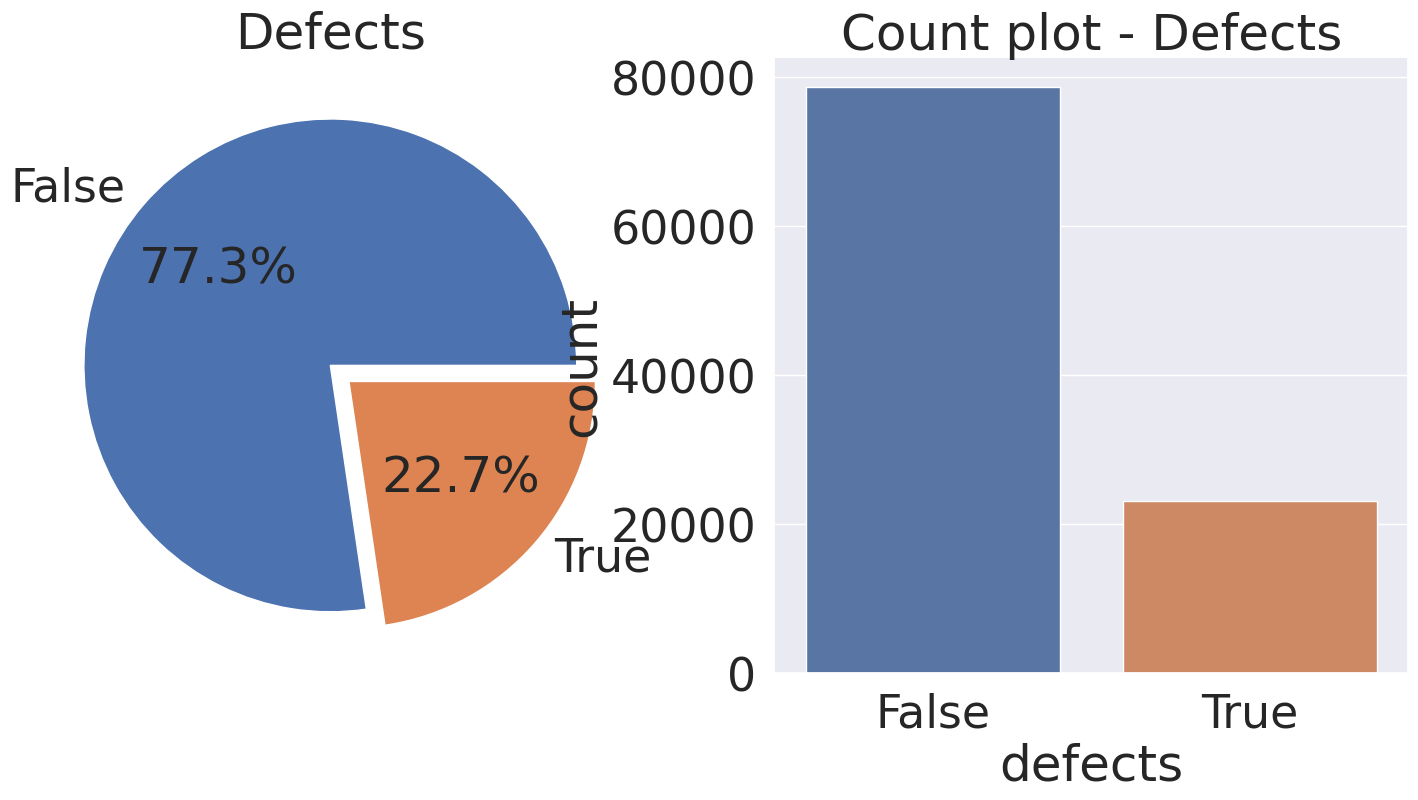

In [12]:
f, ax = plt.subplots(1, 2, figsize = (18,8))

train['defects'].value_counts().plot.pie(explode = [0,0.1], autopct = '%1.1f%%', ax = ax[0])

# Pie plot
ax[0].set_title('Defects')
ax[0].set_ylabel('')

# barplot
sns.countplot(x = 'defects', data = train, ax = ax[1])
ax[1].set_title('Count plot - Defects')

plt.show()

* True: 22.7%
* label에 Slight imbalance가 있다.

# **2. Exploratory Data Analysis**
## **2.1. Numerical Feature Distributions**
* <h4> target label에 따른 데이터의 분포를 비교해보자 </h4>

In [13]:
# defect와 id 제외
cont_cols = train.columns[1:-1]

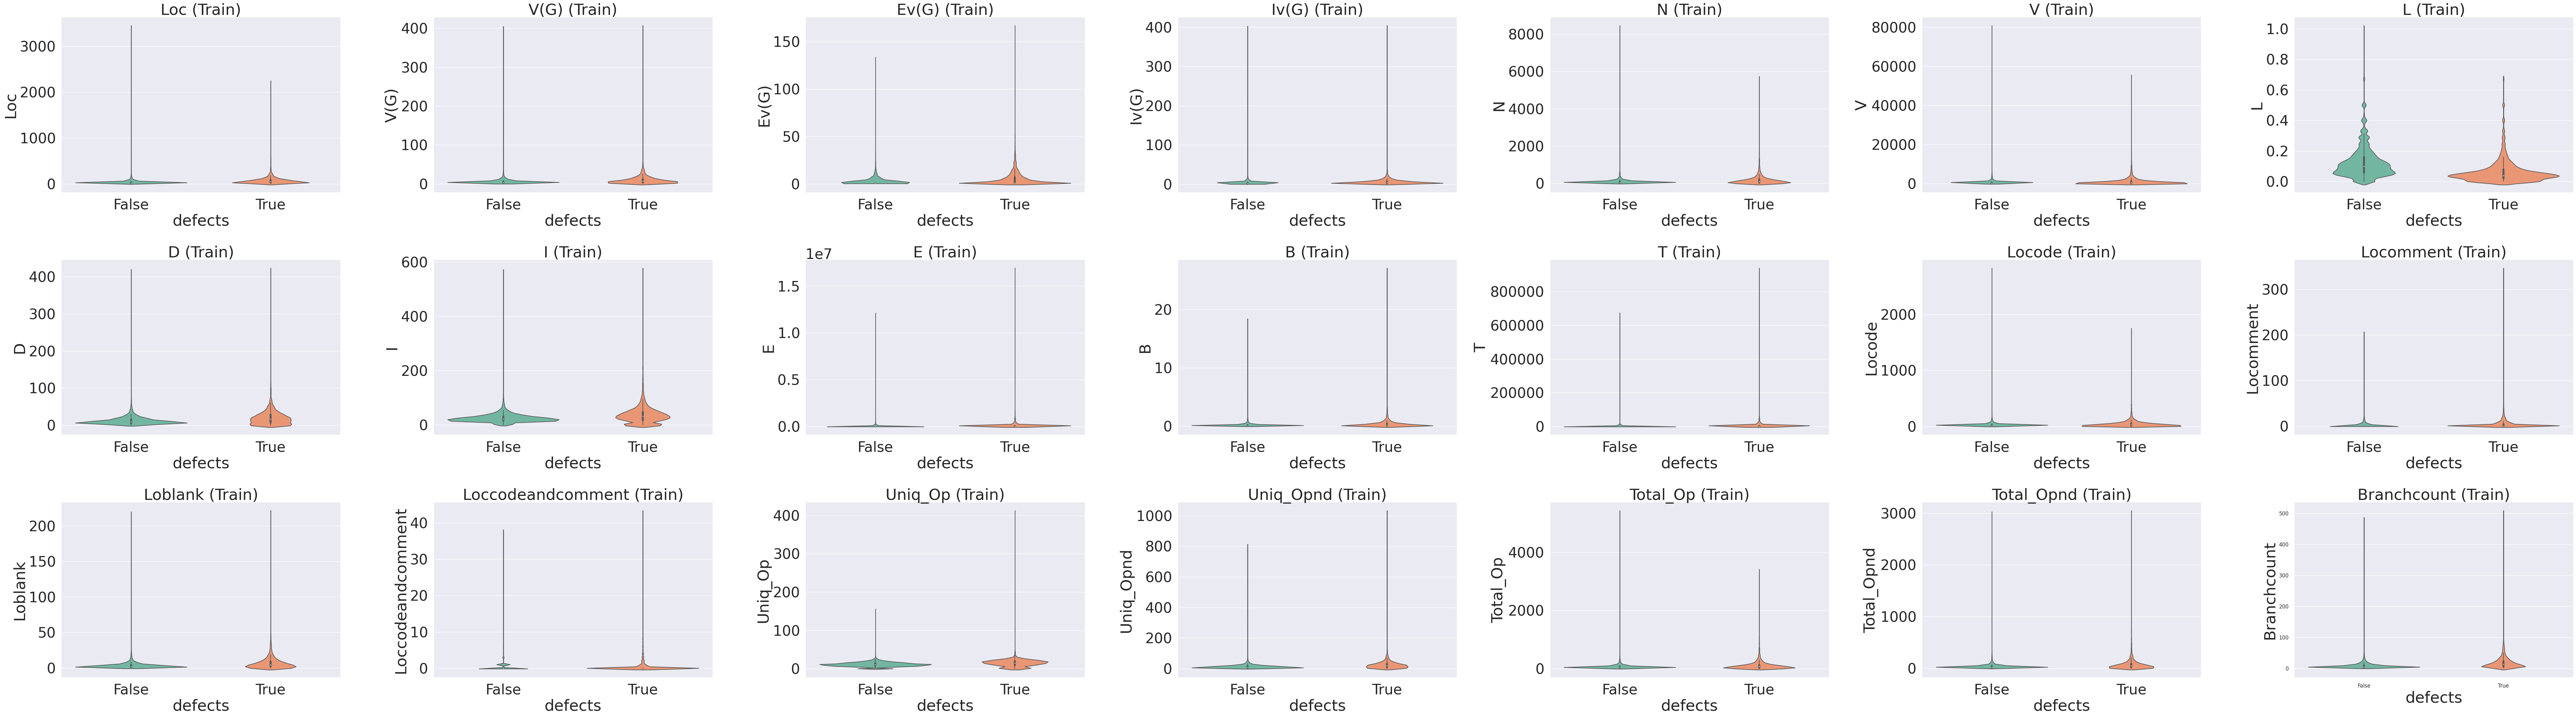

In [14]:
n_rows = 3
n_cols = int(np.ceil(len(cont_cols)/n_rows))


fig, axs = plt.subplots(n_rows, n_cols, figsize = (12 * n_cols, 8 * n_rows))
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
sns.set_palette('Set2')

j = 0
for i, col in enumerate(cont_cols):
    col_num = i % 7 
    if col_num == 0 and i != 0:
        j+=1
    sns.violinplot(x = 'defects', y = col, data = train, ax = axs[j, col_num])
    axs[j, col_num].set_title(f'{col.title()} (Train)')
    axs[j, col_num].set_xlabel('defects')
    axs[j, col_num].set_ylabel(col.title())
    sns.despine()
      
fig.tight_layout()

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

### defects에 따른 데이터의 분포에 차이가 별로 안 보임

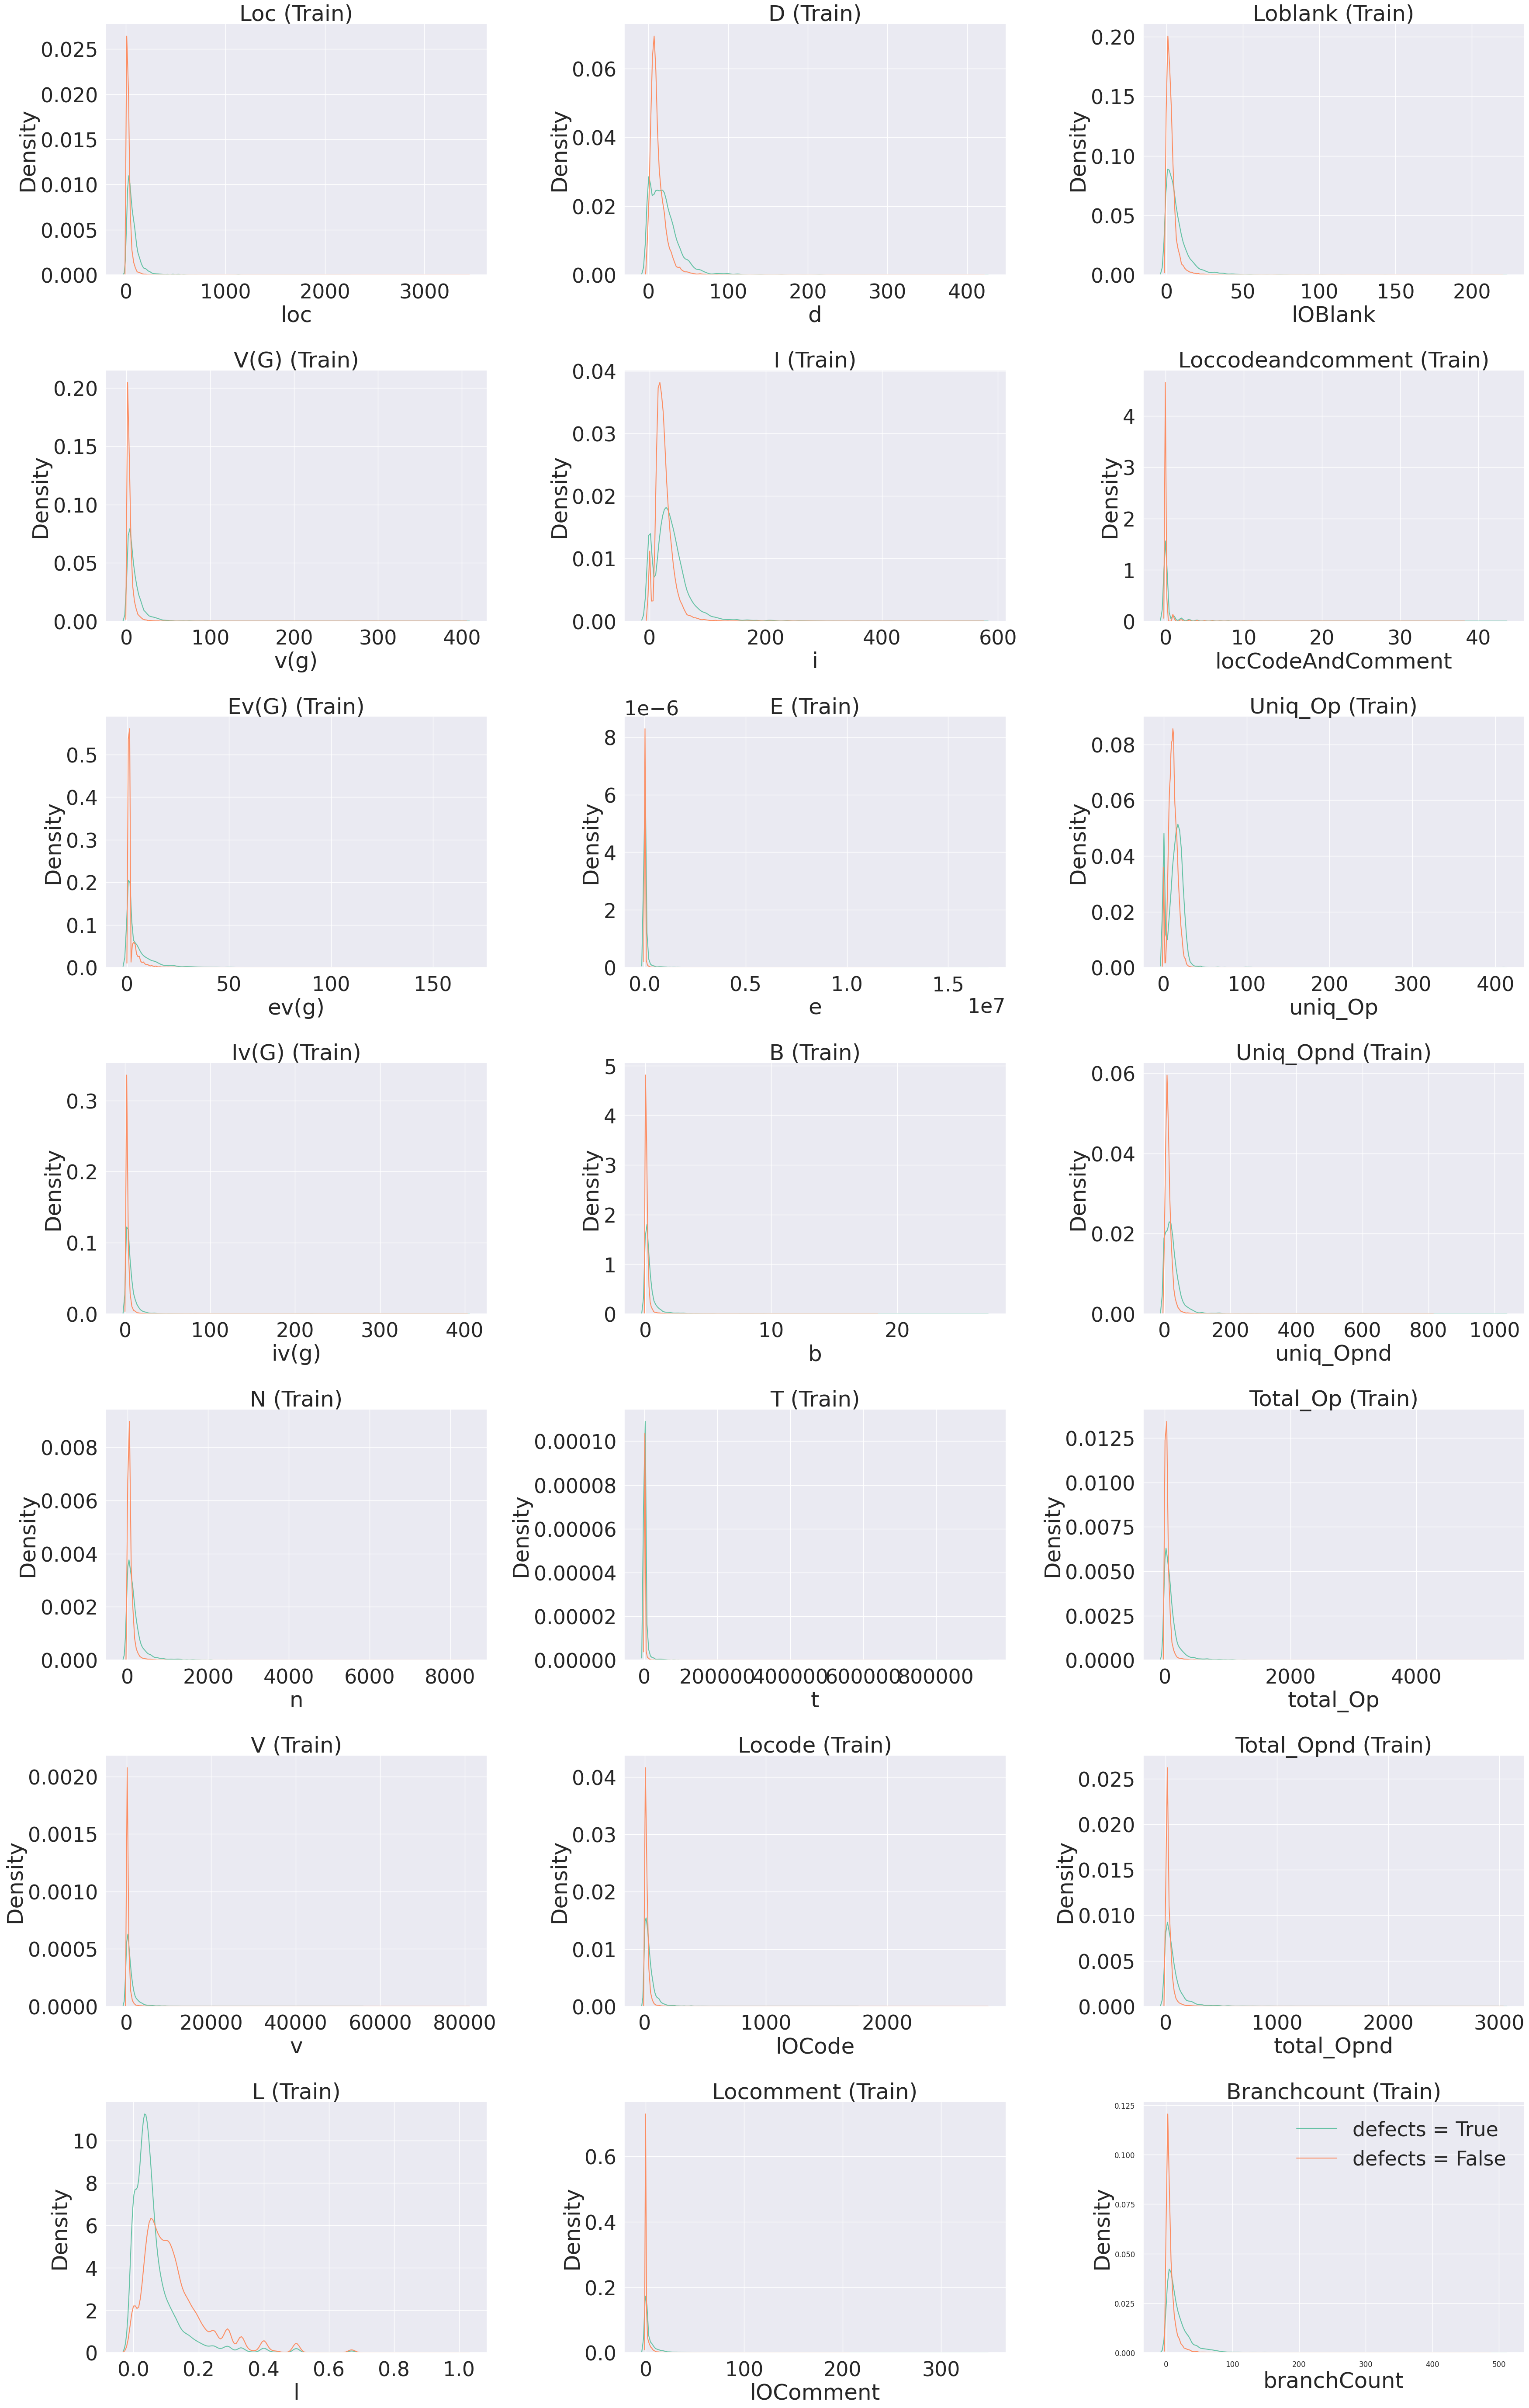

In [15]:
n_rows = 3
n_cols = int(np.ceil(len(cont_cols)/n_rows))

fig, axs = plt.subplots(n_cols, n_rows, figsize = (12 * n_rows, 8 * n_cols))
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
sns.set_palette('Set2')

j = 0
for i, col in enumerate(cont_cols):
    col_num = i % 7 
    if col_num == 0 and i != 0:
        j+=1
    sns.kdeplot(train[train['defects'] == True][col], ax = axs[col_num, j])
    sns.kdeplot(train[train['defects'] == False][col], ax = axs[col_num, j])
    axs[col_num, j].set_title(f'{col.title()} (Train)')
    axs[col_num, j].set_ylabel('Density')
    sns.despine()
    plt.legend(['defects = True', 'defects = False'])
      
fig.tight_layout()

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

### 역시나 defects에 따른 차이가 잘 안보이는 것 같다.

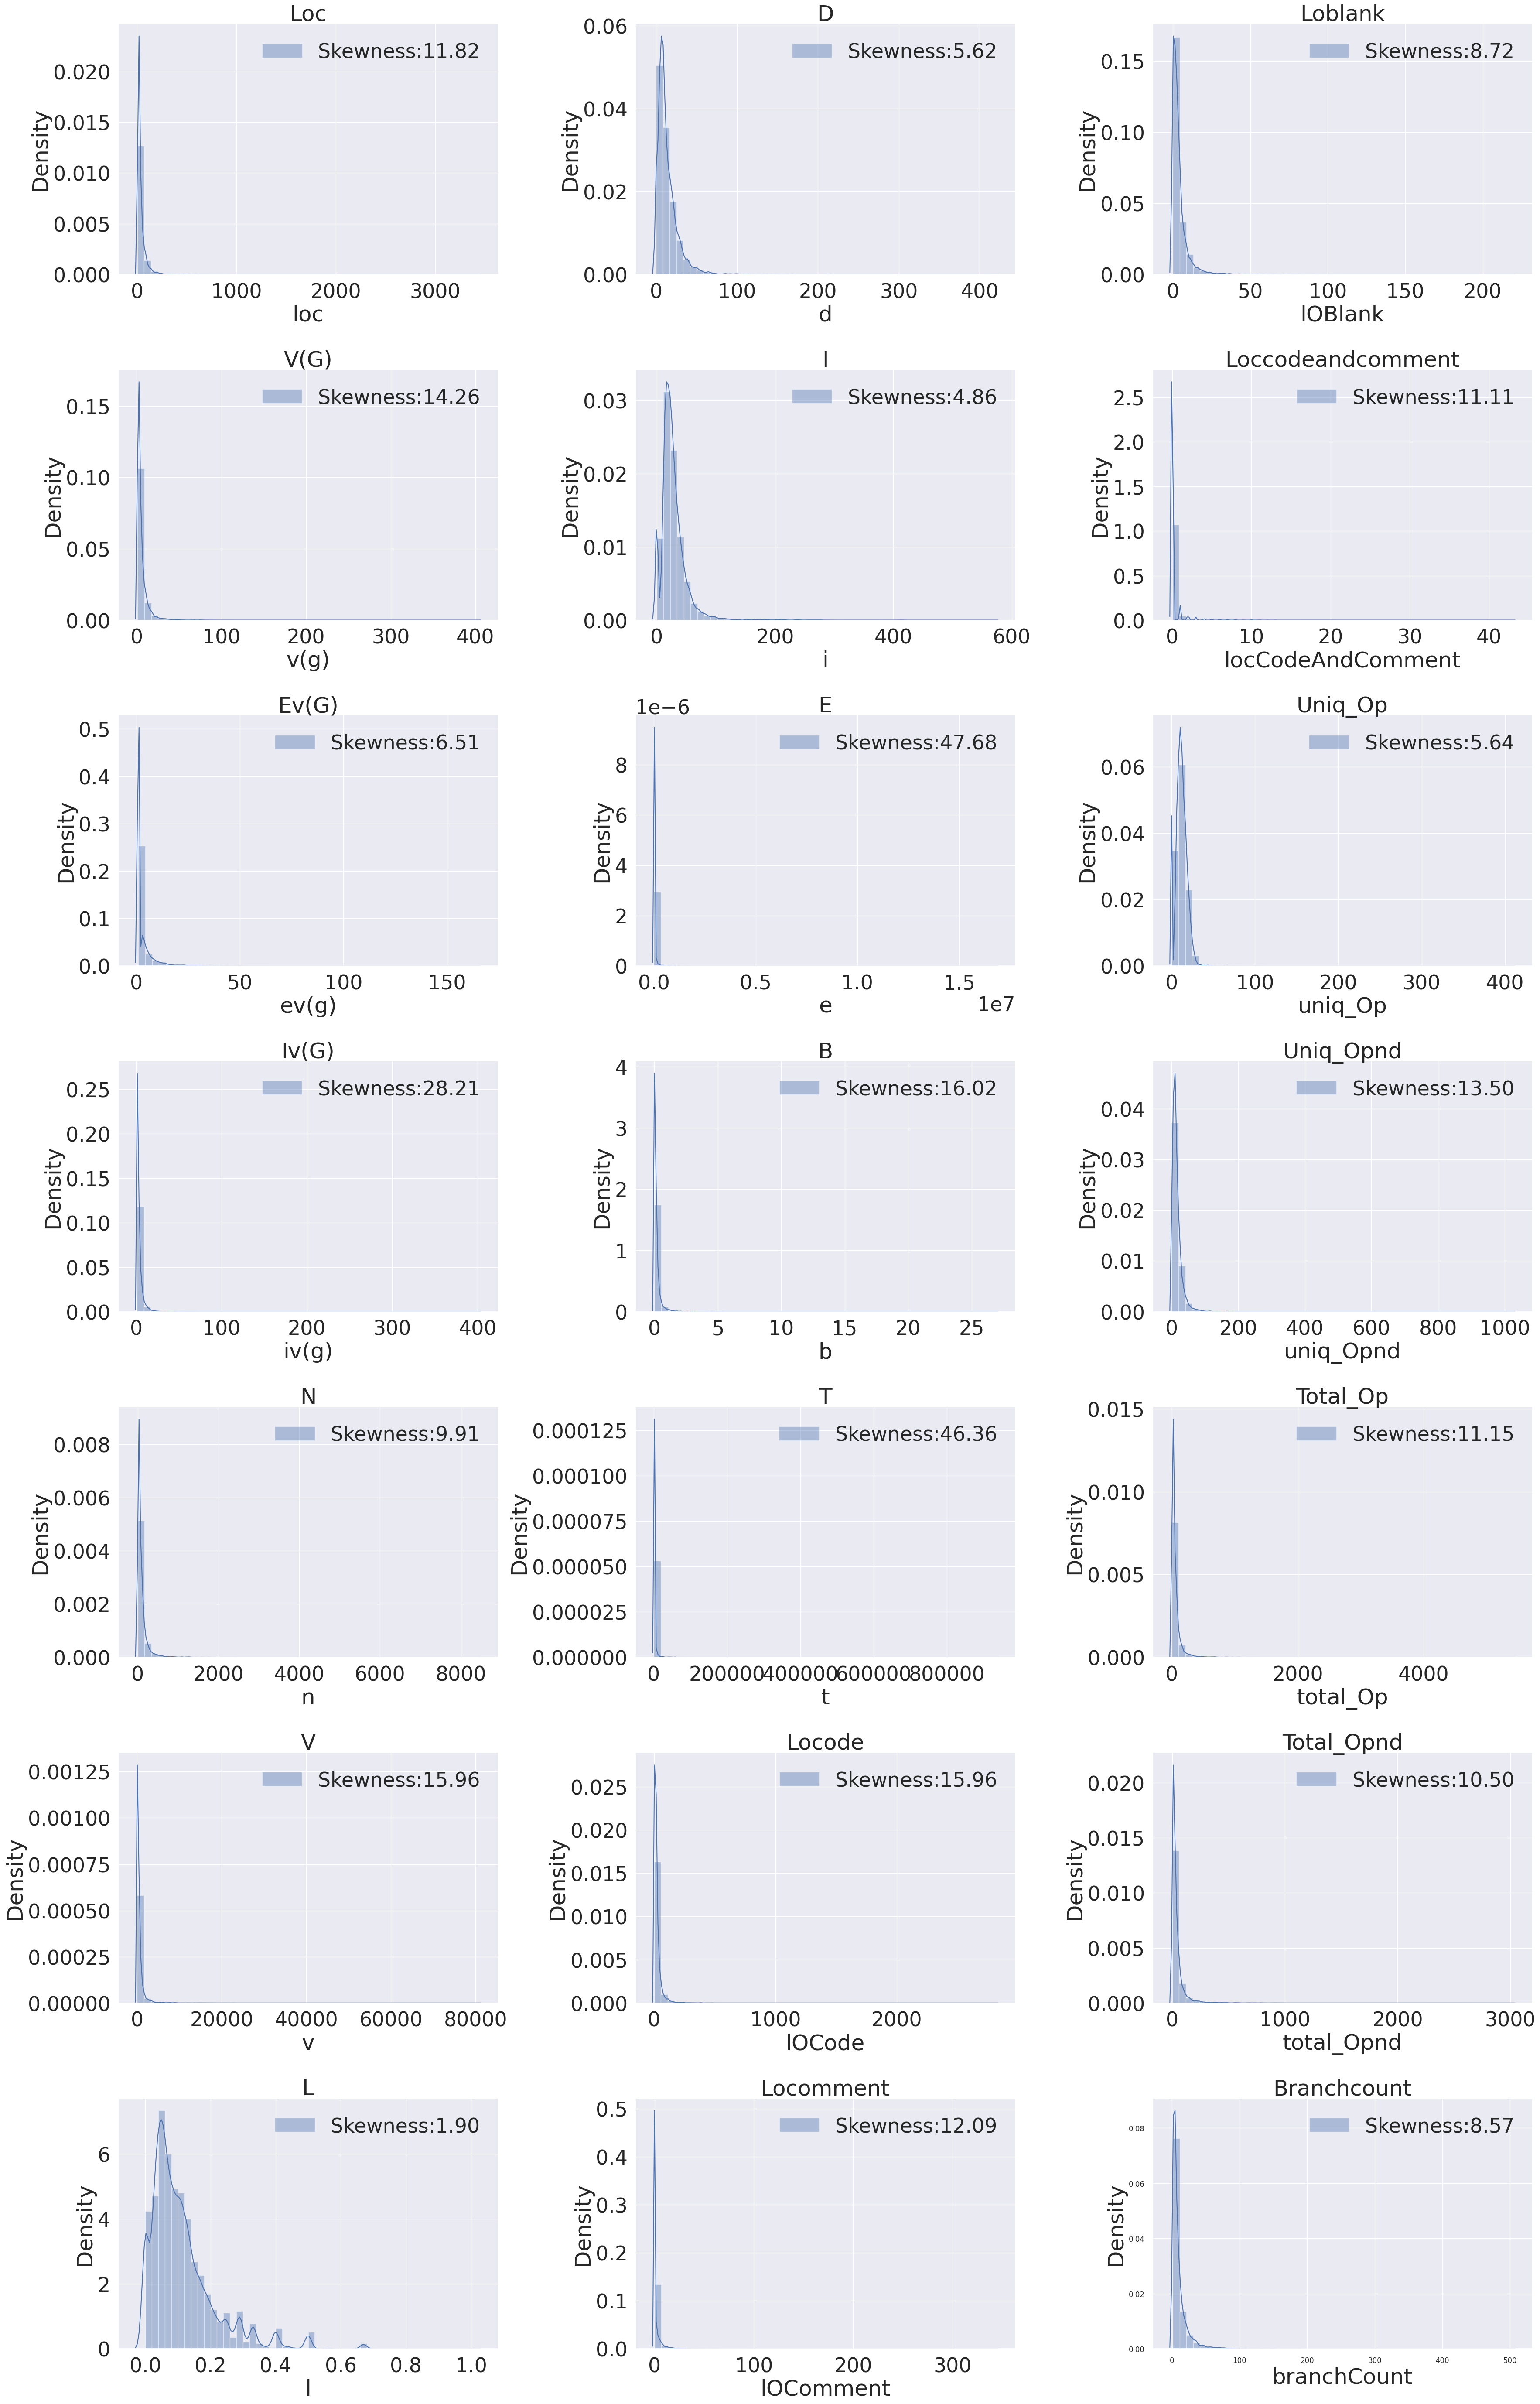

In [31]:
n_rows = 3
n_cols = int(np.ceil(len(cont_cols)/n_rows))

fig, axs = plt.subplots(n_cols, n_rows, figsize = (12 * n_rows, 8 * n_cols))
fig.subplots_adjust(hspace = 0.5, wspace=0.5)

j = 0
for i, col in enumerate(cont_cols):
    col_num = i % 7 
    if col_num == 0 and i != 0:
        j+=1
    sns.distplot(train[col], color = 'b', label = 'Skewness:{:.2f}'.format(train[col].skew()),ax = axs[col_num, j])
    axs[col_num, j].legend(loc = 'best')
    axs[col_num, j].set_title(f'{col.title()}')
    axs[col_num, j].set_ylabel('Density')
    axs[col_num, j].set_xlabel(f'{col}')
    sns.despine()
      
fig.tight_layout()

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

* ### Skewness가 심한 feature가 많다는 것을 알 수 있다.
* ### 특히 t, lv(G), E는 20~50 정도의 왜도를 가지고 있다. -> log 처리?
